In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mljar-supervised
!pip install joblib==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.5-py3-none-any.whl size=147060 sha256=3bb671841900214fbc81895f56d78e0880279259852f83f9bdf5132c5c60d77d
  Stored in directory: /root/.cache/pip/wh

In [3]:
# set project folder directory
DATA_DIR = '/content/drive/MyDrive/W281 Project/data'

In [4]:
# load some lib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,roc_curve
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')
import pickle
import gzip


# read in metadata
df_meta = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_Metadata.csv", index_col = 0)
df_meta

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [5]:
# import data - This should be feature sepecfific
# NOTE: this step is feature specific
# train_image_data =  pickle.load(open(f"{DATA_DIR}/processed/lbp_image_data.pkl", "rb"))
# train_label =  pickle.load(open(f"{DATA_DIR}/processed/lbp_caption_data.pkl", "rb"))

# joblib load
train_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/lbp_image_data.gz", 'rb') )
train_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/lbp_caption_data.gz", 'rb') )


# loading test set
test_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/lbp_test_image_data.gz", 'rb') )
test_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/lbp_test_caption_data.gz", 'rb') )

# load using joblib
# test_image_data = joblib.load(f"{DATA_DIR}/processed/clrs_hist_image_data.pkl")
# test_label = joblib.load(f"{DATA_DIR}/processed/clrs_hist_test_caption_data.pkl")


In [6]:
train_label = np.array(train_label).astype(int)
test_label = np.array(test_label).astype(int)

In [7]:
from sklearn.decomposition import PCA

# compute PCA on the LBP features
# applying PCA components = 50 from earlier analysis
pca=PCA(n_components=50) 
train_image_data_pca=pca.fit_transform(train_image_data)

# applying the same transformation on the test image data
test_image_data_pca=pca.transform(test_image_data)

# Training Simple Multiclass Logistic Regression
Utilizing SIFT features only, train a simple logistic regression

In [ ]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # 1. declare a keras sequential model that's 
  # 2. add first layer for a flatten input layer
  # 3. add dense hidden layer size based on the input list 
  # 4. add a final output layer with softmax activation for multi-class classification purposes
  model = keras.Sequential()
  model.add(keras.layers.Flatten())

  for layer_size in hidden_layer_sizes:
    model.add(keras.layers.Dense(
      units=layer_size,
      activation=activation
    ))

  model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
  ))


  # 5. instantiate an optimization based on input
  if optimizer == 'SGD':
    op = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == 'Adam':
    op = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # compile the model with an opimizer
  model.compile(loss="sparse_categorical_crossentropy", 
                optimizer=op, 
                metrics=['accuracy'])


  return model

In [ ]:
# Build the model.
log_reg_model = build_model(n_classes=3, 
                    hidden_layer_sizes=[512, 256],
                    activation='relu',
                    optimizer='Adam',
                    learning_rate=0.01)


# keras.utils.plot_model(log_reg_model, show_shapes=True, dpi=90)               

In [ ]:
history = log_reg_model.fit(
  x=train_image_data_pca,
  y=train_label,
  epochs=10,
  batch_size=64,
  validation_split=0.1)

Epoch 1/10
303/303 [==============================] - 2s 4ms/step - loss: 38.8083 - accuracy: 0.4337 - val_loss: 1.1318 - val_accuracy: 0.0790
Epoch 2/10
303/303 [==============================] - 1s 4ms/step - loss: 1.0166 - accuracy: 0.4614 - val_loss: 1.2037 - val_accuracy: 0.5634
Epoch 3/10
303/303 [==============================] - 1s 4ms/step - loss: 1.0383 - accuracy: 0.4682 - val_loss: 1.1212 - val_accuracy: 0.1514
Epoch 4/10
303/303 [==============================] - 1s 4ms/step - loss: 1.0169 - accuracy: 0.4643 - val_loss: 1.1262 - val_accuracy: 0.5629
Epoch 5/10
303/303 [==============================] - 1s 4ms/step - loss: 1.0169 - accuracy: 0.4647 - val_loss: 1.1511 - val_accuracy: 0.2531
Epoch 6/10
303/303 [==============================] - 1s 4ms/step - loss: 1.0213 - accuracy: 0.4562 - val_loss: 1.1646 - val_accuracy: 0.2327
Epoch 7/10
303/303 [==============================] - 1s 4ms/step - loss: 1.0700 - accuracy: 0.4350 - val_loss: 1.1337 - val_accuracy: 0.5629
Epoch

In [ ]:
joblib.dump(log_reg_model, f"{DATA_DIR}/outputs/Logistic-LBP-.pkl")

['/content/drive/MyDrive/W281 Project/data/outputs/Logistic-LBP-.pkl']

In [8]:
log_reg_model = joblib.load(f"{DATA_DIR}/outputs/Logistic-LBP-.pkl")

In [9]:
y_pred = np.argmax(log_reg_model.predict(test_image_data_pca), axis=-1)
y_pred

98/98 [==============================] - 1s 2ms/step


array([2, 2, 2, ..., 2, 2, 2])

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

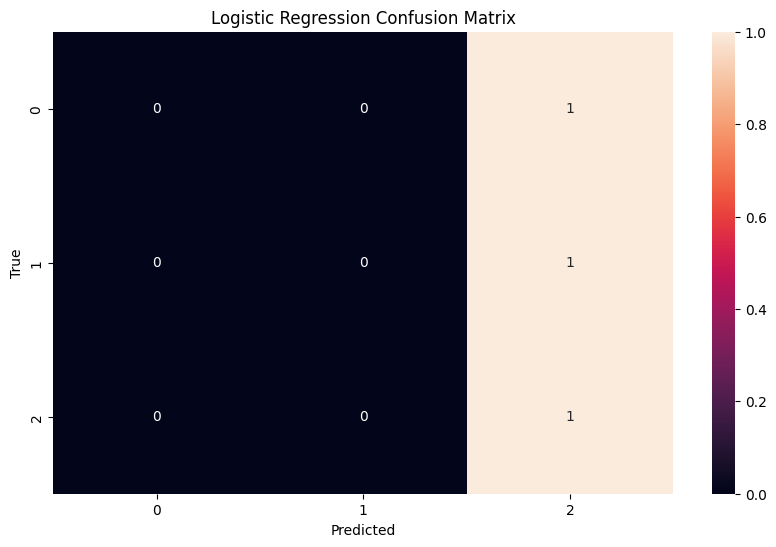

In [10]:

ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression Confusion Matrix")

In [ ]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1170
           1       0.00      0.00      0.00       740
           2       0.39      1.00      0.56      1209

    accuracy                           0.39      3119
   macro avg       0.13      0.33      0.19      3119
weighted avg       0.15      0.39      0.22      3119



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Modeling USING SVM

In [ ]:
# train a quick SVM
from sklearn.svm import SVC

svc_model = SVC(gamma='auto')
svc_model.fit(train_image_data_pca, train_label)

SVC(gamma='auto')

In [ ]:
joblib.dump(svc_model, f"{DATA_DIR}/outputs/SVC-LBP.pkl")

['/content/drive/MyDrive/W281 Project/data/outputs/SVC-LBP.pkl']

In [11]:
svc_model = joblib.load(f"{DATA_DIR}/outputs/SVC-LBP.pkl")

In [12]:
y_pred = svc_model.predict(test_image_data_pca)
y_pred

array([2, 2, 2, ..., 2, 2, 2])

Text(0.5, 1.0, 'SVC Confusion Matrix')

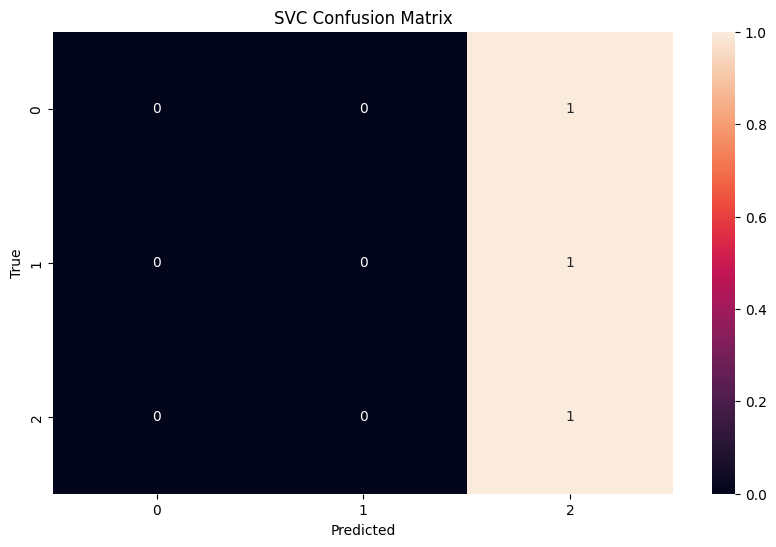

In [13]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVC Confusion Matrix")

In [14]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1170
           1       0.00      0.00      0.00       740
           2       0.39      1.00      0.56      1209

    accuracy                           0.39      3119
   macro avg       0.13      0.33      0.19      3119
weighted avg       0.15      0.39      0.22      3119



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Modeling Using Gradient Boosting

In [ ]:
train_image_data_pca.shape

(21526, 50)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier(n_estimators=300, 
                                       learning_rate=0.1,
                                      max_depth=3).fit(train_image_data_pca, 
                                                       train_label)


In [ ]:
gbc_model.score(test_image_data_pca, test_label)

0.6268034626482847

In [ ]:
joblib.dump(gbc_model, f"{DATA_DIR}/outputs/GBC-LBP.pkl")

['/content/drive/MyDrive/W281 Project/data/outputs/GBC-LBP.pkl']

In [15]:
gbc_model = joblib.load(f"{DATA_DIR}/outputs/GBC-LBP.pkl")

In [16]:
y_pred = gbc_model.predict(test_image_data_pca)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

Text(0.5, 1.0, 'GBC Confusion Matrix')

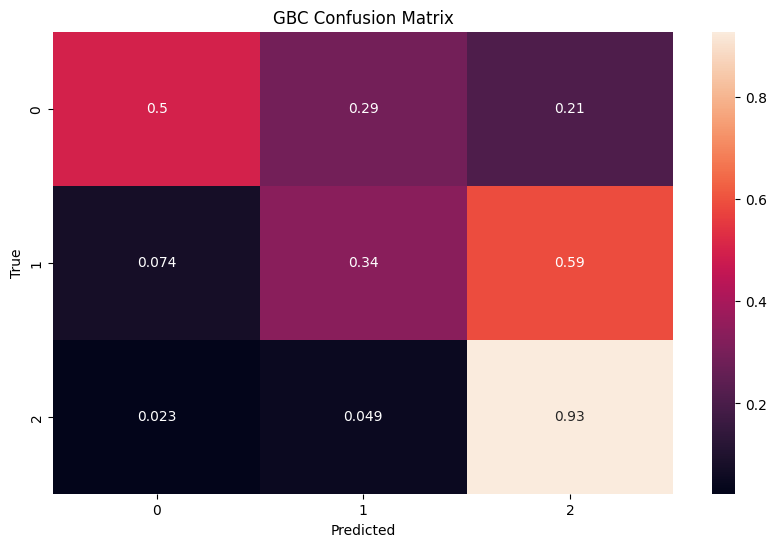

In [17]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GBC Confusion Matrix")

In [18]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.50      0.64      1170
           1       0.38      0.34      0.36       740
           2       0.62      0.93      0.74      1209

    accuracy                           0.63      3119
   macro avg       0.63      0.59      0.58      3119
weighted avg       0.66      0.63      0.61      3119



In [ ]:
# performing AUTOML
# Trying AutoML to determine golden features
# also because I am lazy to try all modeling techniques...
from supervised.automl import AutoML


automl = AutoML(
    mode="Perform", 
    explain_level=1, 
    golden_features=True,
    total_time_limit=30000,
    ml_task="multiclass_classification",
    eval_metric='accuracy',
    validation_strategy={
        "validation_type": "kfold",
        "k_folds": 4,
        "shuffle": False,
        "stratify": True,
})

# upsample training 
automl.fit(train_image_data_pca, train_label)

# save the autoML for future usage
# joblib.dump(automl, f"{DATA_DIR}/outputs/CLRS-HIST-autoMLModel.pkl")

# print the nice report :)
# automl.report()

In [ ]:
automl.report()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# save the autoML for future usage
pickle.dump(automl, open(f"{DATA_DIR}/outputs/LBP-autoMLModel.pkl", "wb"))

In [19]:
automl = pickle.load(open(f"{DATA_DIR}/outputs/LBP-autoMLModel.pkl", "rb"))

In [20]:
# print the report
y_pred = automl.predict(test_image_data_pca)
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int32)

Text(0.5, 1.0, 'AutoML Confusion Matrix')

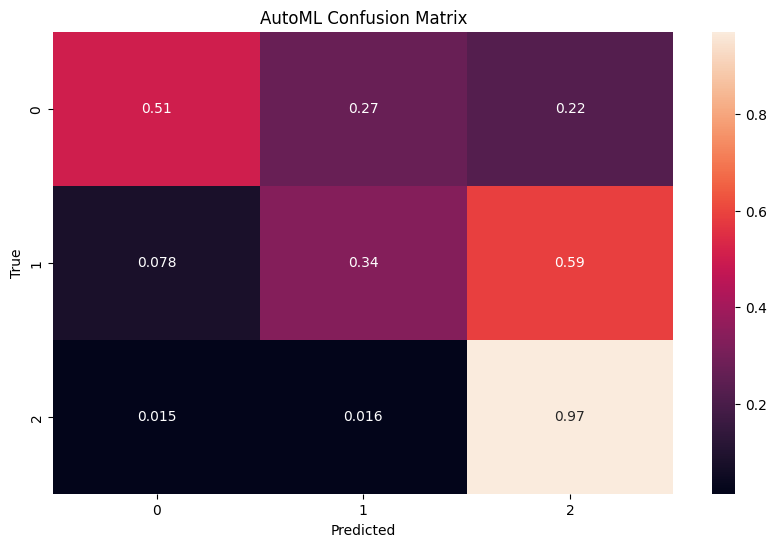

In [21]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("AutoML Confusion Matrix")

In [22]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.51      0.64      1170
           1       0.43      0.34      0.37       740
           2       0.63      0.97      0.76      1209

    accuracy                           0.64      3119
   macro avg       0.65      0.60      0.59      3119
weighted avg       0.68      0.64      0.63      3119



In [ ]:
data = {
    "Logistic Regression": 0.39,
    "SVC": 0.39,
    "GBC": 0.63,
    "autoML": 0.65
}

accuracy = pd.DataFrame().from_dict(data, orient='index')
accuracy

,0
Logistic Regression,0.39
SVC,0.39
GBC,0.63
autoML,0.65


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'SVC'),
  Text(2, 0, 'GBC'),
  Text(3, 0, 'autoML')])

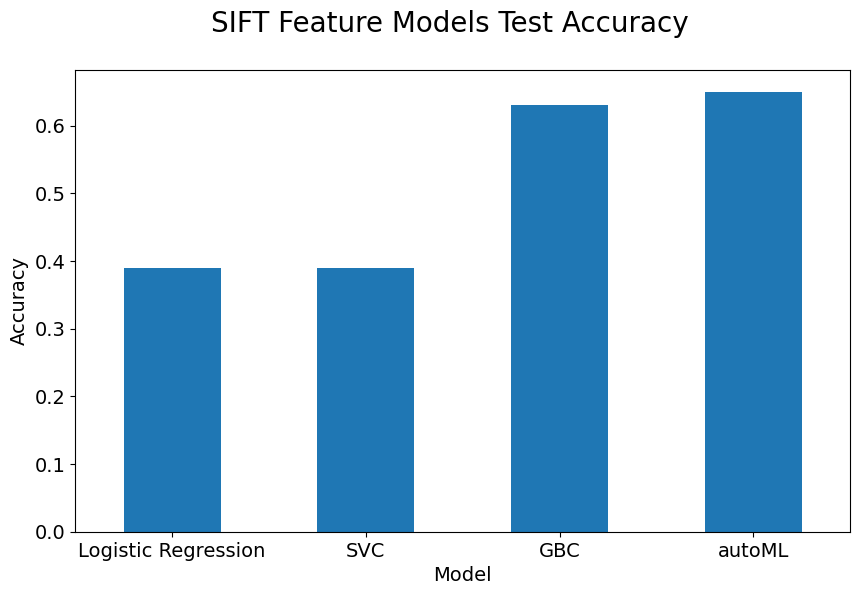

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
accuracy[0].plot(kind='bar')
# set figure title

fig.suptitle('SIFT Feature Models Test Accuracy', fontsize=20)
# set x and y labels
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
